In [1]:
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, merge, Input, concatenate, add
from keras.layers import Conv2D, MaxPooling2D,MaxPool2D, ZeroPadding2D, AveragePooling2D, GlobalAveragePooling2D, BatchNormalization
from keras.utils import np_utils
from keras.models import model_from_json
from keras import backend as K
from keras.preprocessing import image
from keras.optimizers import SGD, RMSprop
from keras.utils.data_utils import get_file
import random
from keras.applications import VGG16, ResNet50, VGG19
import os
import itertools
import cv2
from sklearn.metrics import log_loss, confusion_matrix
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import os
import warnings
warnings.simplefilter("ignore", UserWarning)

Using TensorFlow backend.


In [12]:

from keras.preprocessing.image import ImageDataGenerator
image_width = 64
image_height = 64

img_rows =  224
img_cols =  224
image_size = (image_width, image_height)

data_datagen = ImageDataGenerator(rescale=1.0/255,  validation_split=0.15, featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)

train_generator = data_datagen.flow_from_directory(
        '../input/simpsons_dataset/simpsons_dataset',  # this is the target directory
        target_size=image_size,  # all images will be resized to 224x224
        batch_size=16,
        class_mode='categorical',
         subset='training')

validation_generator = data_datagen.flow_from_directory(
        '../input/simpsons_dataset/simpsons_dataset',  # this is the target directory
        target_size=image_size,  # all images will be resized to 224x224
        batch_size=16,
        class_mode='categorical',
         subset='validation')


Found 11745 images belonging to 10 classes.
Found 2066 images belonging to 10 classes.


In [13]:
conv_base = VGG19(weights='imagenet',  include_top=False, input_shape=(64, 64,3))

In [14]:
for i,layer in enumerate(conv_base.layers):
    print(i,layer.name)

0 input_2
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_conv4
11 block3_pool
12 block4_conv1
13 block4_conv2
14 block4_conv3
15 block4_conv4
16 block4_pool
17 block5_conv1
18 block5_conv2
19 block5_conv3
20 block5_conv4
21 block5_pool


In [15]:
def vgg19_pretrained_model(model_vgg):
    model = Sequential()
    model.add(model_vgg)
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(256, activation = "relu"))
    model.add(Dense(10, activation='softmax'))      
    set_trainable = False
    for layer in model_vgg.layers:
        if layer.name == 'block5_conv3' or layer.name == 'block1_conv2':
             layer.trainable = True     
    model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=0.001), metrics=['acc'])
    
    
    

    return model

In [16]:
model = vgg19_pretrained_model(conv_base)

In [17]:
N_TRAIN =  11745 
N_VALIDA = 2066 
history = model.fit_generator(
        train_generator,
        steps_per_epoch=(N_TRAIN // 128),
        epochs=50,
          validation_data=validation_generator,
        validation_steps= N_VALIDA//128)

Epoch 1/50
91/91 [==============================] - 13s 145ms/step - loss: 2.4094 - acc: 0.1415 - val_loss: 15.1737 - val_acc: 0.0586
Epoch 2/50
91/91 [==============================] - 11s 118ms/step - loss: 2.2706 - acc: 0.1806 - val_loss: 12.1685 - val_acc: 0.0742
Epoch 3/50
91/91 [==============================] - 11s 118ms/step - loss: 2.1210 - acc: 0.2308 - val_loss: 3.4481 - val_acc: 0.1250
Epoch 4/50
91/91 [==============================] - 11s 118ms/step - loss: 2.0859 - acc: 0.2452 - val_loss: 2.6864 - val_acc: 0.1836
Epoch 5/50
91/91 [==============================] - 11s 119ms/step - loss: 2.0212 - acc: 0.2720 - val_loss: 2.5437 - val_acc: 0.1562
Epoch 6/50
91/91 [==============================] - 11s 118ms/step - loss: 1.9343 - acc: 0.3056 - val_loss: 4.2794 - val_acc: 0.1602
Epoch 7/50
91/91 [==============================] - 11s 117ms/step - loss: 1.9215 - acc: 0.3029 - val_loss: 4.1152 - val_acc: 0.1562
Epoch 8/50
91/91 [==============================] - 11s 119ms/step 

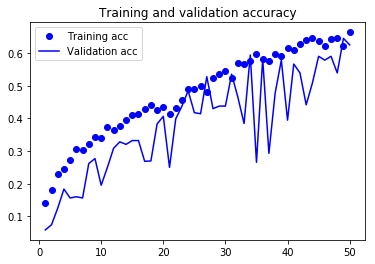

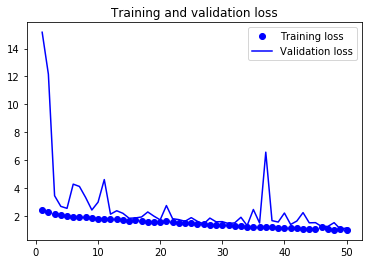

In [18]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend(loc='best')

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc='best');

# Comparativo

* As redes anterios eram bem menores (poucas camadas convolucionais) o que não possibilitou a rede aprender bem com os dados. A VGG19 tem 19 camadas convolucionais já treinada no ImageNet, entretanto, o dataset do simpsons é bem diferente do que a rede VGG19 foi treinada o que fez a gente usar a técnica Fine Tunning forçando a rede treinar algumas camadas e  modificando o final da rede. Preferi modificar as primeiras camadas, pois elas capturam características mais genéricas o que faz a rede conhecer melhor os novos dados.